In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

## statistics
from scipy.stats import zscore
import statsmodels.formula.api as sm

## ML
import PyComplexHeatmap as pyc
from PyComplexHeatmap.utils import define_cmap
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


## Extra
from anndata import read_h5ad

## Load Data

In [2]:
## Load tissue-plasma paired samples
ad = read_h5ad('/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/intermediate/anndata/2024_06_28_pilot_tpb_anndata.h5ad')
tissue_data_snr = ad[ad.obs['specimen_type'] == 'tumor_tissue'].to_df()

"""
## Obtain region scores of each plasma-tissue paired sample
tissue_data = pd.DataFrame()
plasma_data = pd.DataFrame()

for tissue_id in tissue_data_snr.index:

    region_scores = ad[ad.obs['patient_id'] == tissue_id.split("__")[0]].to_df(layer='region_scores')

    tissue_sample = region_scores.query(' index == @tissue_id ')

    plasma_id = tissue_id.split("__")[0] + "__plasma_patient"
    
    plasma_sample = region_scores.query(' index == @plasma_id ')
    
    tissue_data = pd.concat([tissue_data, tissue_sample], axis=0)
    
    plasma_data = pd.concat([plasma_data, plasma_sample ], axis=0)
    

print(f"The shape of tissue data is {tissue_data.shape}")
print(f"The shape of plasma data is {plasma_data.shape}")
"""

'\n## Obtain region scores of each plasma-tissue paired sample\ntissue_data = pd.DataFrame()\nplasma_data = pd.DataFrame()\n\nfor tissue_id in tissue_data_snr.index:\n\n    region_scores = ad[ad.obs[\'patient_id\'] == tissue_id.split("__")[0]].to_df(layer=\'region_scores\')\n\n    tissue_sample = region_scores.query(\' index == @tissue_id \')\n\n    plasma_id = tissue_id.split("__")[0] + "__plasma_patient"\n    \n    plasma_sample = region_scores.query(\' index == @plasma_id \')\n    \n    tissue_data = pd.concat([tissue_data, tissue_sample], axis=0)\n    \n    plasma_data = pd.concat([plasma_data, plasma_sample ], axis=0)\n    \n\nprint(f"The shape of tissue data is {tissue_data.shape}")\nprint(f"The shape of plasma data is {plasma_data.shape}")\n'

In [3]:
## Load tissue-plasma paired samples' meta-data
columns = ["unique_sample_id", "sample_id", "age","qc_status", "histological_subtype", "flowcell", "molecule_file_path", "g360_max_maf_pct"]

meta_info = pd.read_csv("/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/resources/metadata/2024-06-23_updated_pilot_TPB_and_cf_Ep1_Epiv2p0_with_epiTFgamma.tsv", sep="\t").\
    loc[:,columns]

## tissue meta-data
tissue_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__tumor_tissue") ').\
    merge(meta_info, how="left", on="unique_sample_id")

plasma_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__plasma_patient") ').\
    merge(meta_info, how="left", on="unique_sample_id")

print(f"The shape of tissue meta-data is {tissue_meta.shape}")
print(f"The shape of plasma meta-data is {plasma_meta.shape}")

tissue_plasma_meta = pd.concat([tissue_meta,plasma_meta],axis=0)
print(f"The shape of tissue_plasma meta-data is {tissue_plasma_meta.shape}")

## Save
save = False
if save:
    tissue_meta.to_csv("/screening/notebooks/zhuang/summer_2024/data/tissue_meta_data.tsv", sep="\t")
    plasma_meta.to_csv("/screening/notebooks/zhuang/summer_2024/data/plasma_meta_data.tsv", sep="\t")

    print("saved!")

## original regions meta-data before filtering
tissue_regions_meta = pd.read_csv('/screening/analysis/2024_03_29_MCD_intermediate_files/intermediate/s3_region_design/s3_v1.2b_V6_noCntrl_and_tcga_overlap_EP1_full.tsv', sep='\t')

The shape of tissue meta-data is (25, 17)
The shape of plasma meta-data is (25, 17)
The shape of tissue_plasma meta-data is (50, 17)


In [4]:
tissue_plasma_meta.apply(lambda x: x.isna().sum()/len(x))

patient_id_specimen     0.00
unique_sample_id        0.00
patient_id              0.00
specimen_type           0.00
sample_group            0.00
epi_tf                  0.00
stage_group             0.00
breast_s3_logitMAF      0.00
CRCv2_logitMAF          0.00
LungV4_logitMAF         0.00
sample_id               0.00
age                     0.00
qc_status               0.00
histological_subtype    0.28
flowcell                0.00
molecule_file_path      0.00
g360_max_maf_pct        1.00
dtype: float64

In [5]:
## load tissue-plasma paired samples' region scores
tissue_plasma_lung_region_scores = pd.read_csv("/home/eforouzmand/repos/gh-eforouzmand/2024-Jul-09-Tissue-Plasma-Comparisons/tissue_plasma_lung_region_scores.tsv", sep="\t")

## Missing sample filtering
missing_patient_id_specimen = tissue_plasma_meta.query('~sample_id.isin(@tissue_plasma_lung_region_scores.run_sample_id) ').patient_id_specimen.iloc[0].split("__")[0]
missing_run_sample_id = tissue_plasma_meta.query(' patient_id_specimen.str.startswith(@missing_patient_id_specimen) ').sample_id

tissue_plasma_meta = tissue_plasma_meta.query(' ~sample_id.isin(@missing_run_sample_id) ').\
    set_index("sample_id")

print(f"Meta-data shape after filtering: {tissue_plasma_meta.shape}")

tissue_plasma_lung_region_scores = tissue_plasma_lung_region_scores.query(' ~run_sample_id.isin(@missing_run_sample_id) ').\
    set_index("run_sample_id")

print(f"Region score data shape after filtering: {tissue_plasma_lung_region_scores.shape}")

Meta-data shape after filtering: (48, 16)
Region score data shape after filtering: (48, 3598)


In [6]:
## Load regions scores and clustering results of lung samples
flavor = "v1.2b_eldoradorius_b"

s3_v4_model = pd.read_table("/home/eforouzmand/repos/gh-eforouzmand/2024-Jun-12-Lung-S3-in-region-discovery/intermediate_data/CANDIDATE_S3_Lung_-_V4.model_file.98_spec_set_on_s3_data.tsv")

kmeans_4cluster_lung = pd.read_csv("/home/eforouzmand/repos/gh-eforouzmand/2024-Jun-27-Lung-Methyl-Subtypes-ISDs/tcga/4cluster_lung_kmeans.tsv", sep="\t").\
    set_index("unique_sample_id")

## remove duplicated IDs
data_matrix = pd.concat([pd.read_feather(f"/screening/data/methylation/sandbox_pipeline/flavors_spacebox_train/{flavor}/intermediate_files/merged.msre_caller_mr_features.wideform.fth", columns=["unique_sample_id"] + list(s3_v4_model.region_id)), 
                         pd.read_feather(f"/screening/data/methylation/sandbox_pipeline/flavors_spacebox_ldt/{flavor}/intermediate_files/merged.msre_caller_mr_features.wideform.fth", columns=["unique_sample_id"] + list(s3_v4_model.region_id))]).\
    query('unique_sample_id.isin(@kmeans_4cluster_lung.index)').\
    drop_duplicates(subset=["unique_sample_id"], keep='first').\
    set_index("unique_sample_id")

print(f"The shape of the k-means clustering results is: {kmeans_4cluster_lung.shape}")
print(f"The shape of its association region score data is {data_matrix.shape}")

The shape of the k-means clustering results is: (4788, 83)
The shape of its association region score data is (4788, 3598)


## Double-z scores

In [7]:
## From "data_matrix", compute the mean and std of each region as reference
data_matrix_arr = data_matrix.values
sample_means = np.mean(data_matrix_arr, axis=1, keepdims=True)
sample_stds = np.std(data_matrix_arr, axis=1, keepdims=True)

## z-scoring of each row(sample)
data_matrix_arr = (data_matrix_arr - sample_means)/sample_stds

## z-scoring of each column(region)
region_means_ref = np.mean(data_matrix_arr, axis=0, keepdims=True)
region_stds_ref = np.std(data_matrix_arr, axis=0, keepdims=True)

data_matrix_arr = (data_matrix_arr - region_means_ref)/region_stds_ref

## convert back to data frame
data_matrix_z = pd.DataFrame(data_matrix_arr,
                             index = data_matrix.index,
                             columns = data_matrix.columns)

data_matrix_z.head()

s3_region_26389  s3_region_22508  \
unique_sample_id                                                             
A091340801_231218_A01902_0280_BHMFJVDSX7        -1.420936        -1.515038   
A091346801_231218_A01835_0189_AHMG2KDSX7        -0.309183        -0.298221   
A091346401_231218_A01835_0189_AHMG2KDSX7         0.197761         0.256631   
A091345001_231218_A01835_0189_AHMG2KDSX7        -0.915737        -0.962096   
A091342301_231218_A01902_0280_BHMFJVDSX7        -0.967837        -1.019120   

                                          s3_region_22604  s3_region_26760  \
unique_sample_id                                                             
A091340801_231218_A01902_0280_BHMFJVDSX7        -0.470381        -1.490488   
A091346801_231218_A01835_0189_AHMG2KDSX7        -0.551788        -0.211413   
A091346401_231218_A01835_0189_AHMG2KDSX7        -0.047028         0.371828   
A091345001_231218_A01835_0189_AHMG2KDSX7         0.125812        -0.909254   
A091342301_231218_A01902_0280_BHMFJVDSX7        -1.207605        -0.969196   

                                          s3_region_17285  s3_region_8296  \
unique_sample_id                                                            
A091340801_231218_A01902_0280_BHMFJVDSX7        -0.143592       -1.439195   
A091346801_231218_A01835_0189_AHMG2KDSX7        -0.236352       -0.221873   
A091346401_231218_A01835_0189_AHMG2KDSX7         0.338799        0.333210   
A091345001_231218_A01835_0189_AHMG2KDSX7         0.535742       -0.886023   
A091342301_231218_A01902_0280_BHMFJVDSX7        -0.315598       -0.943071   

                                          s3_region_27052  s3_region_19545  \
unique_sample_id                                                             
A091340801_231218_A01902_0280_BHMFJVDSX7        -0.203673        -1.475258   
A091346801_231218_A01835_0189_AHMG2KDSX7        -0.296286        -0.259392   
A091346401_231218_A01835_0189_AHMG2KDSX7         0.277954         0.295026   
A091345001_231218_A01835_0189_AHMG2KDSX7         0.474585         0.484869   
A091342301_231218_A01902_0280_BHMFJVDSX7        -1.042376        -0.979728   

                                          s3_region_23501  s3_region_15145  \
unique_sample_id                                                             
A091340801_231218_A01902_0280_BHMFJVDSX7        -1.449265        -1.447109   
A091346801_231218_A01835_0189_AHMG2KDSX7        -0.377569        -0.237317   
A091346401_231218_A01835_0189_AHMG2KDSX7         0.111110         0.314331   
A091345001_231218_A01835_0189_AHMG2KDSX7         0.278443         1.332524   
A091342301_231218_A01902_0280_BHMFJVDSX7        -1.012492        -0.954054   

                                          ...  merged_462  merged_184  \
unique_sample_id                          ...                           
A091340801_231218_A01902_0280_BHMFJVDSX7  ...   -0.297288    0.216328   
A091346801_231218_A01835_0189_AHMG2KDSX7  ...   -1.929392   -1.104974   
A091346401_231218_A01835_0189_AHMG2KDSX7  ...   -1.612005    1.220826   
A091345001_231218_A01835_0189_AHMG2KDSX7  ...   -0.421504    0.780028   
A091342301_231218_A01902_0280_BHMFJVDSX7  ...   -1.284521   -0.247172   

                                          s3_region_3718  s3_region_13486  \
unique_sample_id                                                            
A091340801_231218_A01902_0280_BHMFJVDSX7        0.051897        -0.450032   
A091346801_231218_A01835_0189_AHMG2KDSX7        0.332559        -0.659277   
A091346401_231218_A01835_0189_AHMG2KDSX7       -1.503674         0.017698   
A091345001_231218_A01835_0189_AHMG2KDSX7       -1.392732        -1.588436   
A091342301_231218_A01902_0280_BHMFJVDSX7        1.194536         0.724008   

                                          s3_region_27348  s3_region_27149  \
unique_sample_id                                                             
A091340801_231218_A01902_0280_BHMFJVDSX7        -1.444999         0.291381   
A091346801_231218_A01835_018

In [8]:
## Compute the double-z scorez of tissue-plasma pairs, using the parameters of regions from "data_matrix"
tissue_plasma_lung_region_scores = tissue_plasma_lung_region_scores.loc[:,list(data_matrix.columns)]

tissue_plasma_lung_arr = tissue_plasma_lung_region_scores.values

sample_means = np.mean(tissue_plasma_lung_arr, axis=1, keepdims=True)
sample_stds = np.std(tissue_plasma_lung_arr, axis=1, keepdims=True)

## z-scoring of each row(sample)
tissue_plasma_lung_arr = (tissue_plasma_lung_arr - sample_means)/sample_stds



## z-scoring of each column(region), use the parameters from "data_matrix" !!!
tissue_plasma_lung_arr = (tissue_plasma_lung_arr - region_means_ref)/region_stds_ref

## convert back to data frame
tissue_plasma_lung_z = pd.DataFrame(tissue_plasma_lung_arr,
                                    index = tissue_plasma_lung_region_scores.index,
                                    columns = tissue_plasma_lung_region_scores.columns)

tissue_plasma_lung_z.head()

s3_region_26389  s3_region_22508  s3_region_22604  \
run_sample_id                                                                
DEI0074_003_HlU4IA9CJw6        -1.629151        -1.742929        -1.866070   
DEI0074_005_UdocMriuAW2        -1.617921        -1.730638        -1.854889   
DEI0074_010_s0MLcpaqVh6         1.646521        -0.393511        -0.483633   
DEI0074_018_c78l9MDcUaz        -0.268782        -0.058652        -0.661501   
DEI0074_020_2K7crc01r55        -1.506505        -1.608693         0.074439   

                         s3_region_26760  s3_region_17285  s3_region_8296  \
run_sample_id                                                               
DEI0074_003_HlU4IA9CJw6        -1.730039        -1.733917       -1.667181   
DEI0074_005_UdocMriuAW2        -0.985695        -1.721176       -0.958773   
DEI0074_010_s0MLcpaqVh6        -1.840566        -0.526480       -0.925864   
DEI0074_018_c78l9MDcUaz        -0.864483        -1.088368       -0.440487   
DEI0074_020_2K7crc01r55        -1.588935        -1.594769       -1.532890   

                         s3_region_27052  s3_region_19545  s3_region_23501  \
run_sample_id                                                                
DEI0074_003_HlU4IA9CJw6        -1.791478        -1.372375        -0.553850   
DEI0074_005_UdocMriuAW2        -1.391780        -1.690690        -1.026315   
DEI0074_010_s0MLcpaqVh6        -1.280557         1.216000        -1.215184   
DEI0074_018_c78l9MDcUaz         3.248341        -0.293139        -0.570031   
DEI0074_020_2K7crc01r55        -1.652551        -1.568840         0.228707   

                         s3_region_15145  ...  merged_462  merged_184  \
run_sample_id                             ...                           
DEI0074_003_HlU4IA9CJw6        -1.673685  ...    1.108305   -0.267815   
DEI0074_005_UdocMriuAW2        -1.661465  ...    0.779945   -1.089267   
DEI0074_010_s0MLcpaqVh6        -1.182865  ...   -0.901617   -0.128815   
DEI0074_018_c78l9MDcUaz        -0.193354  ...    0.220534   -0.829409   
DEI0074_020_2K7crc01r55         0.447081  ...    0.695517    0.330543   

                         s3_region_3718  s3_region_13486  s3_region_27348  \
run_sample_id                                                               
DEI0074_003_HlU4IA9CJw6        1.290156         1.177157        -1.051312   
DEI0074_005_UdocMriuAW2        1.674056         1.308130        -0.800197   
DEI0074_010_s0MLcpaqVh6        0.777386        -0.150521        -0.523849   
DEI0074_018_c78l9MDcUaz        0.307113         0.897274         2.752509   
DEI0074_020_2K7crc01r55        0.369129         1.142183         0.378879   

                         s3_region_27149  s3_region_8257  s3_region_16209  \
run_sample_id                                                               
DEI0074_003_HlU4IA9CJw6         1.040993       -1.030279         0.165388   
DEI0074_005_UdocMriuAW2         0.306579       -0.638837        -0.234047   
DEI0074_010_s0MLcpaqVh6        -0.719609       -0.607515        -0.647176   
DEI0074_018_c78l9MDcUaz         1.406998       -0.675876        -1.275809   
DEI0074_020_2K7crc01r55        -0.287829       -0.221687        -0.150879   

                         s3_region_8258  s3_region_19  
run_sample_id                                          
DEI0074_003_HlU4IA9CJw6       -1.190758     -1.373842  
DEI0074_005_UdocMriuAW2       -0.354387     -0.119169  
DEI0074_010_s0MLcpaqVh6       -0.115143      0.550431  
DEI0074_018_c78l9MDcUaz       -1.003413     -1.587822  
DEI0074_020_2K7crc01r55       -0.620744     -0.022337  

[5 rows x 3598 columns]

## Obtain the mean of each cluster

In [9]:
cluster_means = pd.merge(data_matrix_z, kmeans_4cluster_lung[["cluster_samples"]], how="left", left_index=True, right_index=True).\
    groupby("cluster_samples").\
    apply(lambda df: df.sum(axis=0)/len(df))

cluster_means.head()

s3_region_26389  s3_region_22508  s3_region_22604  \
cluster_samples                                                      
blue                    0.751707         0.743959         0.421464   
green                  -0.360640        -0.431979        -0.538173   
orange                 -0.028016         0.014750        -0.008099   
red                    -0.767235        -0.740578        -0.102307   

                 s3_region_26760  s3_region_17285  s3_region_8296  \
cluster_samples                                                     
blue                    0.759024         0.739085        0.783286   
green                  -0.412029        -0.374035       -0.427063   
orange                  0.045109         0.036236        0.027801   
red                    -0.824619        -0.820020       -0.824047   

                 s3_region_27052  s3_region_19545  s3_region_23501  \
cluster_samples                                                      
blue                    0.655861         0.768308         0.669563   
green                  -0.480348        -0.382312        -0.214728   
orange                  0.087249         0.004395        -0.026921   
red                    -0.651968        -0.814529        -0.787922   

                 s3_region_15145  ...  merged_462  merged_184  s3_region_3718  \
cluster_samples                   ...                                           
blue                    0.788616  ...    0.111759    0.270320       -0.322411   
green                  -0.380507  ...   -0.330745   -0.049472       -0.196382   
orange                 -0.023107  ...    0.297020   -0.276671        0.425883   
red                    -0.811132  ...   -0.237744   -0.000333        0.129196   

                 s3_region_13486  s3_region_27348  s3_region_27149  \
cluster_samples                                                      
blue                    0.047745         0.474159         0.094514   
green                  -0.408571        -0.290474        -0.139882   
orange                  0.424512         0.044422         0.156599   
red                    -0.230397        -0.503558        -0.215336   

                 s3_region_8257  s3_region_16209  s3_region_8258  s3_region_19  
cluster_samples                                                                 
blue                   0.494813        -0.209644        0.490007      0.688327  
green                 -0.174967        -0.401366        0.002300      0.012395  
orange                -0.007944         0.514414       -0.109097     -0.294405  
red                   -0.581872         0.041978       -0.617581     -0.688116  

[4 rows x 3598 columns]

## Compute Euclidean distance of each tissue-plasma paired sample to cluster mean

In [10]:
A = tissue_plasma_lung_z.values
B = cluster_means.values

diff = A[:, np.newaxis,:] - B
dist = np.sqrt(np.sum(diff**2,axis=2))

cluster_dist = pd.DataFrame(dist,
                    index = tissue_plasma_lung_z.index,
                    columns = cluster_means.index.values)

cluster_dist["cluster_samples"] = cluster_dist.idxmin(axis=1)

cluster_dist.head()

blue      green     orange        red  \
run_sample_id                                                         
DEI0074_003_HlU4IA9CJw6  62.427567  43.143888  63.617463  65.409415   
DEI0074_005_UdocMriuAW2  57.257073  39.876072  58.219584  62.322093   
DEI0074_010_s0MLcpaqVh6  54.392729  45.518744  62.564488  68.972428   
DEI0074_018_c78l9MDcUaz  66.230581  66.305837  51.923232  60.857086   
DEI0074_020_2K7crc01r55  58.322364  49.186901  65.614707  71.327828   

                        cluster_samples  
run_sample_id                            
DEI0074_003_HlU4IA9CJw6           green  
DEI0074_005_UdocMriuAW2           green  
DEI0074_010_s0MLcpaqVh6           green  
DEI0074_018_c78l9MDcUaz          orange  
DEI0074_020_2K7crc01r55           green

## Compare the clusters between each pair

In [11]:
cluster_dist = pd.merge(cluster_dist, tissue_plasma_meta, how="left", left_index=True, right_index=True)

save = False

if save:
    cluster_dist.to_csv("/screening/notebooks/zhuang/summer_2024/data/plasma_tissue_cluster.tsv", sep="\t")

match_pairs = []

for id in cluster_dist.patient_id.unique():
    pair = cluster_dist.query(' patient_id == @id ')
    if pair.cluster_samples.nunique() == 1:
        match_pairs.append(id)

cluster_dist = cluster_dist.assign(matched = lambda df: np.where(df["patient_id"].isin(match_pairs), 1, 0))

def convert_hist_subtypes(x):

    if isinstance(x, str):
    
        if x.find("adenocarcinoma") != -1:
            return "adenocarcinoma"
        
        if x.find("squamous_cell_carcinoma") != -1:
            return "squamous_cell_carcinoma"
    else:
        return "unknown"

cluster_dist["histological_subtype"] = cluster_dist["histological_subtype"].map(convert_hist_subtypes)
cluster_dist["log_epi_tf"] = np.log(cluster_dist["epi_tf"])
cluster_dist['patient_id'] = cluster_dist['patient_id'].astype("object")
cluster_dist['patient_id_specimen'] = cluster_dist['patient_id_specimen'].astype("object")
cluster_dist['specimen_type'] = cluster_dist['specimen_type'].astype("object")

## save
cluster_dist.to_csv("/screening/notebooks/zhuang/summer_2024/data/plasma_tissue_cluster.tsv", sep="\t")

In [12]:
cluster_dist.head()

blue      green     orange        red  \
run_sample_id                                                         
DEI0074_003_HlU4IA9CJw6  62.427567  43.143888  63.617463  65.409415   
DEI0074_005_UdocMriuAW2  57.257073  39.876072  58.219584  62.322093   
DEI0074_010_s0MLcpaqVh6  54.392729  45.518744  62.564488  68.972428   
DEI0074_018_c78l9MDcUaz  66.230581  66.305837  51.923232  60.857086   
DEI0074_020_2K7crc01r55  58.322364  49.186901  65.614707  71.327828   

                        cluster_samples          patient_id_specimen  \
run_sample_id                                                          
DEI0074_003_HlU4IA9CJw6           green  MT9923-0016__plasma_patient   
DEI0074_005_UdocMriuAW2           green  MT9923-0019__plasma_patient   
DEI0074_010_s0MLcpaqVh6           green  MT9923-0032__plasma_patient   
DEI0074_018_c78l9MDcUaz          orange  MT9923-0044__plasma_patient   
DEI0074_020_2K7crc01r55           green  MT9923-0049__plasma_patient   

                                                          unique_sample_id  \
run_sample_id                                                                
DEI0074_003_HlU4IA9CJw6  DEI0074_003_HlU4IA9CJw6_240613_lh00141_0093_A2...   
DEI0074_005_UdocMriuAW2  DEI0074_005_UdocMriuAW2_240613_lh00141_0093_A2...   
DEI0074_010_s0MLcpaqVh6  DEI0074_010_s0MLcpaqVh6_240613_lh00141_0093_A2...   
DEI0074_018_c78l9MDcUaz  DEI0074_018_c78l9MDcUaz_240613_lh00141_0093_A2...   
DEI0074_020_2K7crc01r55  DEI0074_020_2K7crc01r55_240613_lh00141_0093_A2...   

                          patient_id   specimen_type sample_group  ...  \
run_sample_id                                                      ...   
DEI0074_003_HlU4IA9CJw6  MT9923-0016  plasma_patient         lung  ...   
DEI0074_005_UdocMriuAW2  MT9923-0019  plasma_patient         lung  ...   
DEI0074_010_s0MLcpaqVh6  MT9923-0032  plasma_patient         lung  ...   
DEI0074_018_c78l9MDcUaz  MT9923-0044  plasma_patient         lung  ...   
DEI0074_020_2K7crc01r55  MT9923-0049  plasma_patient         lung  ...   

                         CRCv2_logitMAF LungV4_logitMAF   age  qc_status  \
run_sample_id                                                              
DEI0074_003_HlU4IA9CJw6      -22.357041      -19.729874  56.0  undefined   
DEI0074_005_UdocMriuAW2      -21.129629      -18.626114  71.0  undefined   
DEI0074_010_s0MLcpaqVh6      -20.938277      -18.755893  69.0  undefined   
DEI0074_018_c78l9MDcUaz      -10.733597       18.878510  68.0  undefined   
DEI0074_020_2K7crc01r55      -22.967312      -20.220862  65.0  undefined   

                            histological_subtype   flowcell  \
run_sample_id                                                 
DEI0074_003_HlU4IA9CJw6           adenocarcinoma  22CGTWLT4   
DEI0074_005_UdocMriuAW2  squamous_cell_carcinoma  22CGTWLT4   
DEI0074_010_s0MLcpaqVh6  squamous_cell_carcinoma  22CGTWLT4   
DEI0074_018_c78l9MDcUaz  squamous_cell_carcinoma  22CGTWLT4   
DEI0074_020_2K7crc01r55           adenocarcinoma  22CGTWLT4   

                                                        molecule_file_path  \
run_sample_id                                                                
DEI0074_003_HlU4IA9CJw6  /screening/analysis/2024_05_13_tissue_enhanced...   
DEI0074_005_UdocMriuAW2  /screening/analysis/2024_05_13_tissue_enhanced...   
DEI0074_010_s0MLcpaqVh6  /screening/analysis/2024_05_13_tissue_enhanced...   
DEI0074_018_c78l9MDcUaz  /screening/analysis/2024_05_13_tissue_enhanced...   
DEI0074_020_2K7crc01r55  /screening/analysis/2024_05_13_tissue_enhanced...   

                        g360_max_maf_pct matched log_epi_tf  
run_sample_id                                                
DEI0074_003_HlU4IA9CJw6              NaN       0  -4.234994  
DEI0074_005_UdocMriuAW2              NaN       0  -5.905671  
DEI0074_010_s0MLcpaqVh6              NaN       1  -5.707734  
DEI0074_018_c78l9MDcUaz              NaN       0  -0.429419  
DEI0074_020_2K7crc01r55              NaN       0  -7.233882  

[5 r

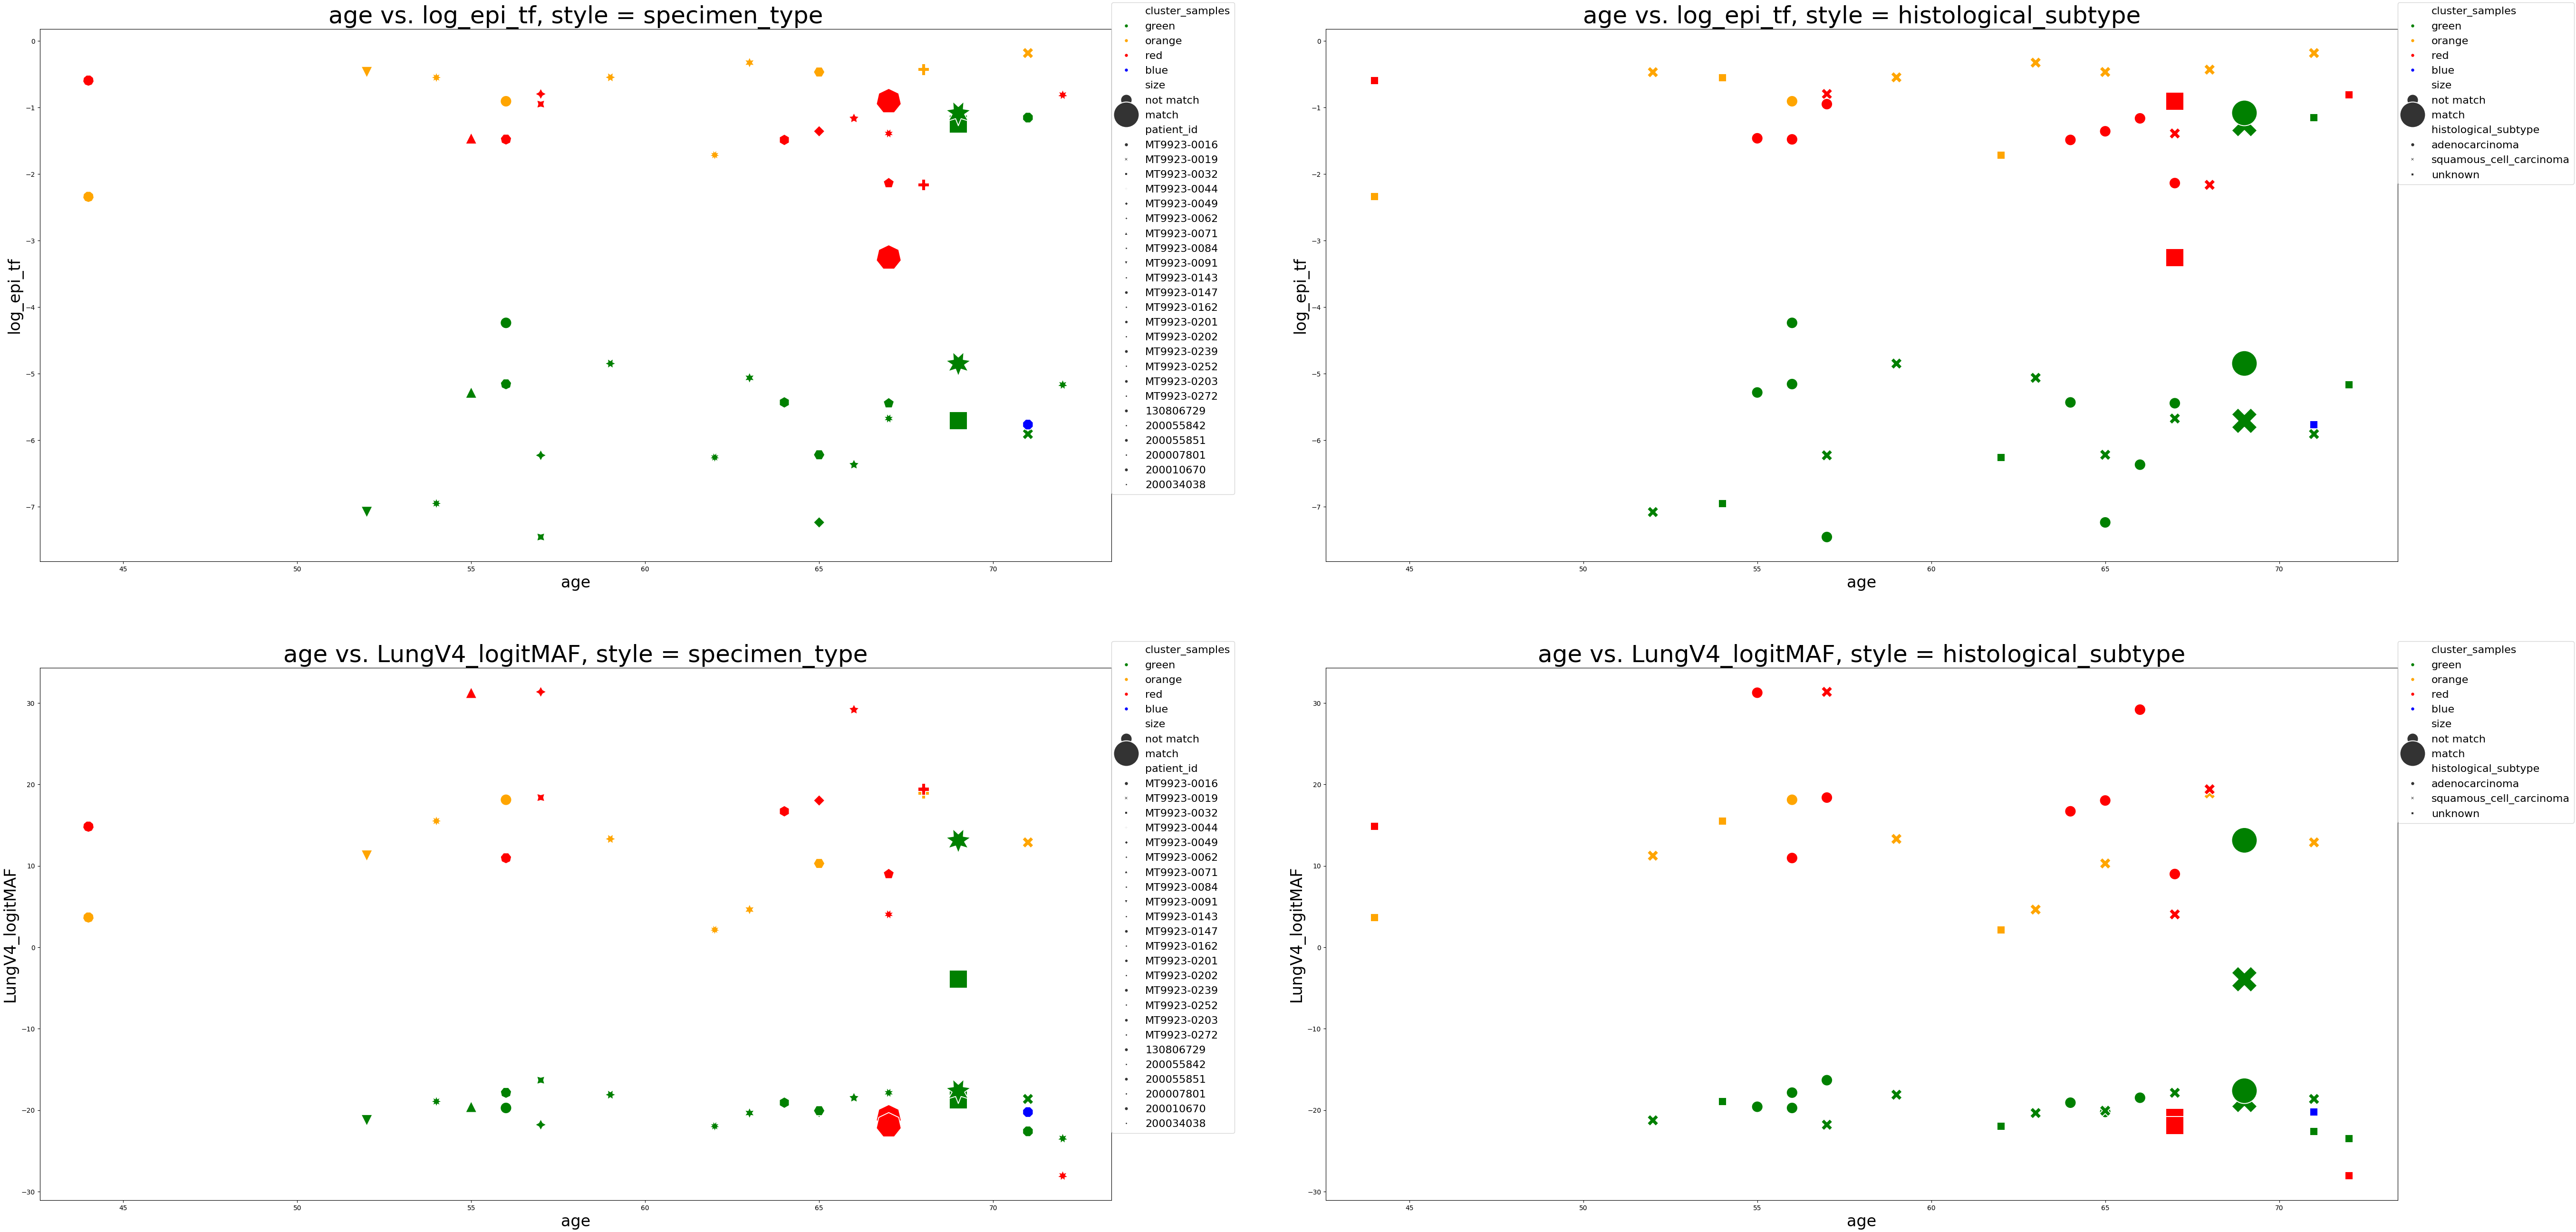

In [13]:
custom_palette = {"green": "green",
                  "orange": "orange",
                  "red" : "red",
                  "blue": "blue"}

size_mapping = {0: "not match",
                1: "match"}

cluster_dist["size"] = cluster_dist["matched"].map(size_mapping)
                  
fig, axes = plt.subplots(2,2,figsize=(64,32))

with plt.style.context('_classic_test_patch'):
     
    sns.scatterplot(x = "age",
                    y = "log_epi_tf",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    style = "patient_id",
                    data = cluster_dist,
                    size = "size",
                    sizes = (1500, 300),
                    ax = axes[0,0])

    axes[0,0].set_xlabel('age', fontsize=24)
    axes[0,0].set_ylabel('log_epi_tf', fontsize=24)
    axes[0,0].set_title('age vs. log_epi_tf, style = specimen_type', fontsize=36)
    axes[0,0].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 16})


    sns.scatterplot(x = "age",
                    y = "log_epi_tf",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    style = "histological_subtype",
                    data = cluster_dist,
                    size = "size",
                    sizes = (1500, 300),
                    ax = axes[0,1])

    axes[0,1].set_xlabel('age', fontsize=24)
    axes[0,1].set_ylabel('log_epi_tf', fontsize=24)
    axes[0,1].set_title('age vs. log_epi_tf, style = histological_subtype', fontsize=36)
    axes[0,1].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 16})

    
    sns.scatterplot(x = "age",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    style = "patient_id",
                    data = cluster_dist,
                    size = "size",
                    sizes = (1500, 300),
                    ax = axes[1,0])

    axes[1,0].set_xlabel('age', fontsize=24)
    axes[1,0].set_ylabel('LungV4_logitMAF', fontsize=24)
    axes[1,0].set_title('age vs. LungV4_logitMAF, style = specimen_type', fontsize=36)
    axes[1,0].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 16})

    sns.scatterplot(x = "age",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    style = "histological_subtype",
                    data = cluster_dist,
                    size = "size",
                    sizes = (1500, 300),
                    ax = axes[1,1])

    
    axes[1,1].set_xlabel('age', fontsize=24)
    axes[1,1].set_ylabel('LungV4_logitMAF', fontsize=24)
    axes[1,1].set_title('age vs. LungV4_logitMAF, style = histological_subtype', fontsize=36)
    axes[1,1].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 16})

    

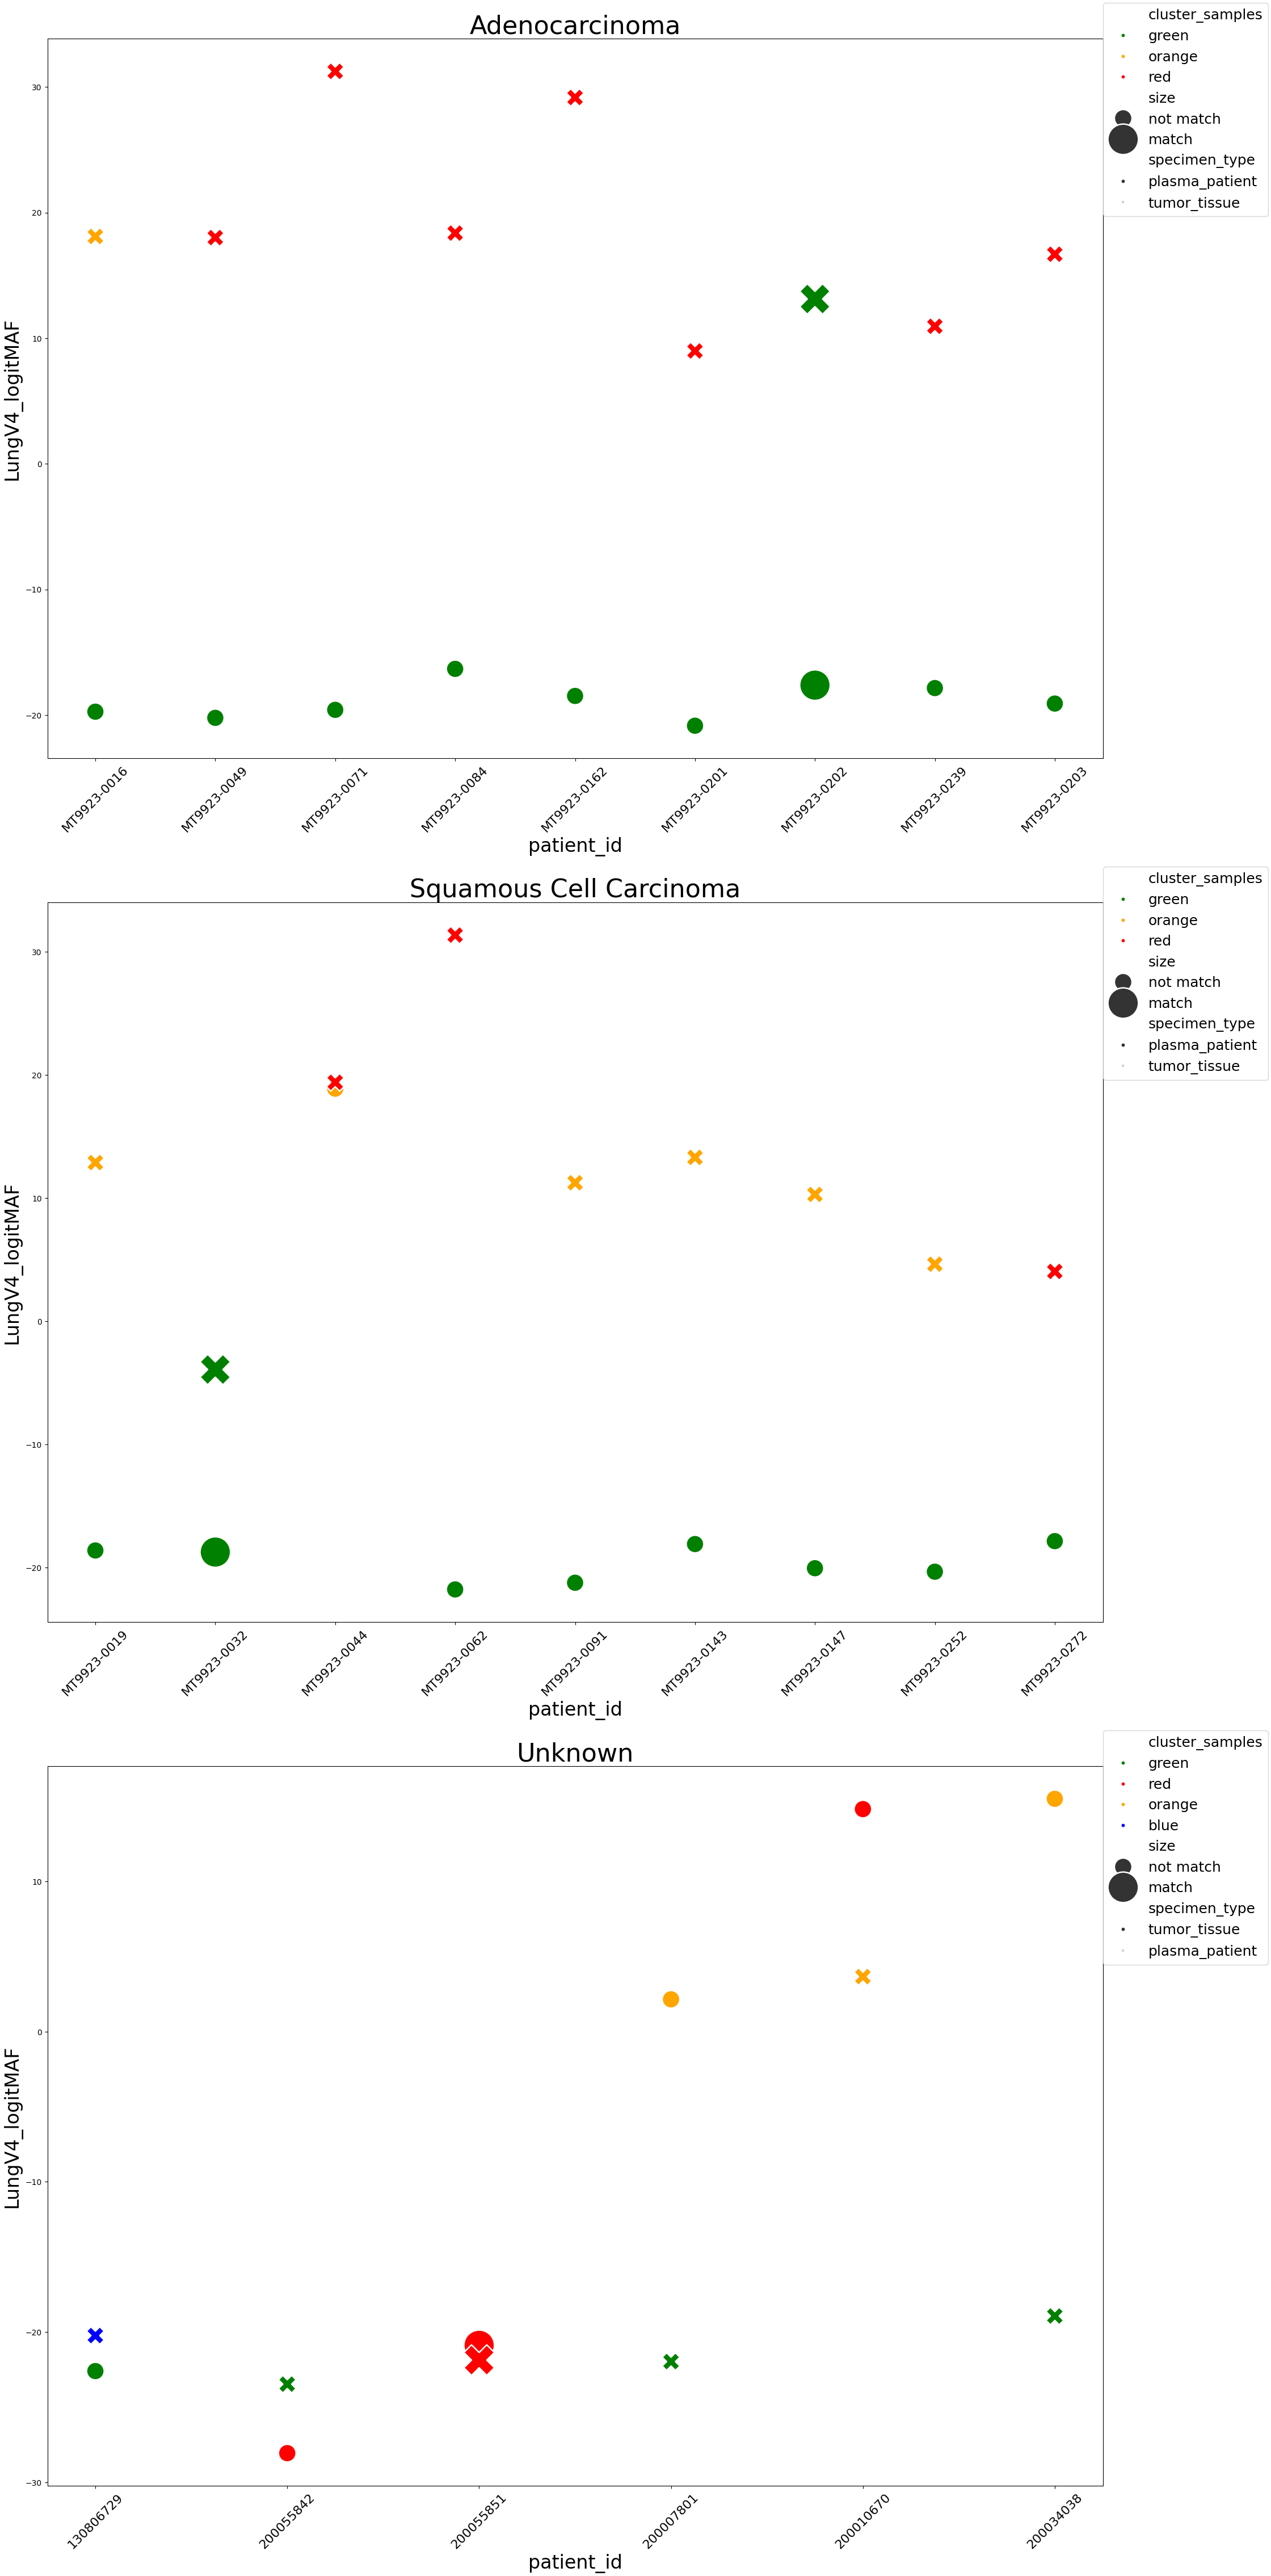

In [14]:
adeno = cluster_dist.query('histological_subtype == "adenocarcinoma"')
squamous = cluster_dist.query('histological_subtype == "squamous_cell_carcinoma"')
unknown = cluster_dist.query('histological_subtype == "unknown"')

fig, axes = plt.subplots(3,1,figsize=(24,56))

with plt.style.context('_classic_test_patch'):
     
    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = adeno,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[0])

    axes[0].set_xlabel('patient_id', fontsize=24)
    axes[0].set_ylabel("LungV4_logitMAF", fontsize=24)
    axes[0].set_title('Adenocarcinoma', fontsize=32)
    axes[0].tick_params(axis="x", labelsize=16)
    axes[0].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = squamous,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[1])

    axes[1].set_xlabel('patient_id', fontsize=24)
    axes[1].set_ylabel("LungV4_logitMAF", fontsize=24)
    axes[1].set_title('Squamous Cell Carcinoma', fontsize=32)
    axes[1].tick_params(axis="x", labelsize=16)
    axes[1].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    
    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = unknown,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[2])

    axes[2].set_xlabel('patient_id', fontsize=24)
    axes[2].set_ylabel("LungV4_logitMAF", fontsize=24)
    axes[2].set_title('Unknown', fontsize=32)
    axes[2].tick_params(axis="x", labelsize=16)
    axes[2].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})
    

    for ax in axes.flatten():
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

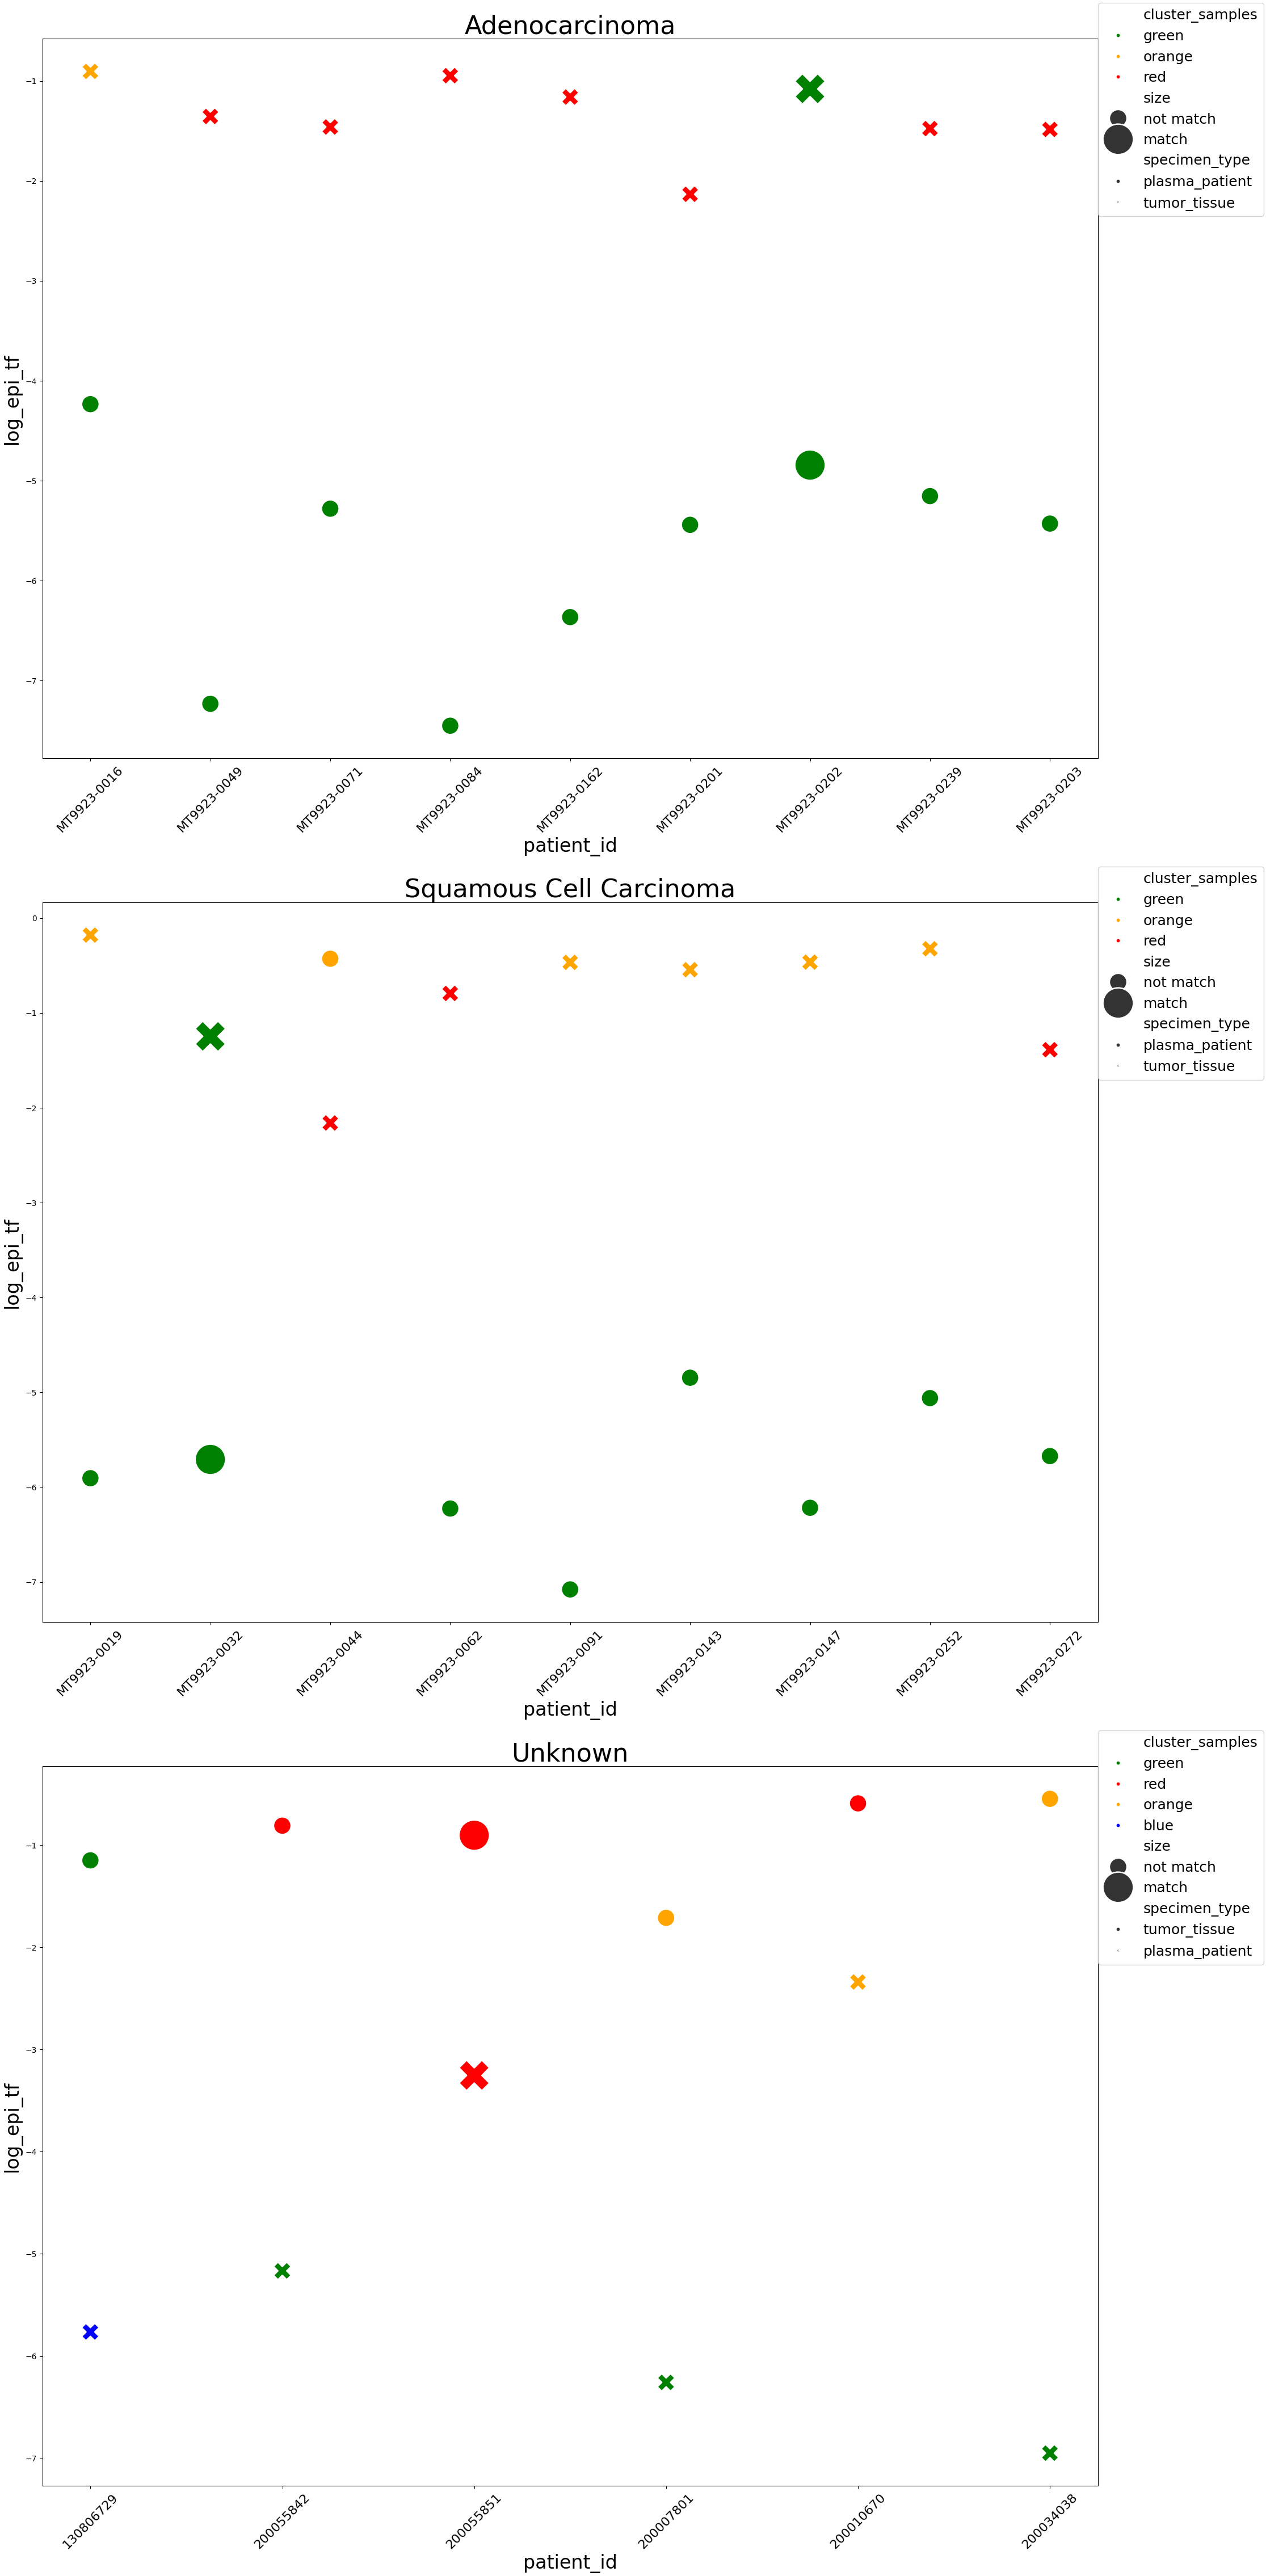

In [15]:
fig, axes = plt.subplots(3,1,figsize=(24,56))

with plt.style.context('_classic_test_patch'):
     
    sns.scatterplot(x = "patient_id",
                    y = "log_epi_tf",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = adeno,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[0])

    axes[0].set_xlabel('patient_id', fontsize=24)
    axes[0].set_ylabel("log_epi_tf", fontsize=24)
    axes[0].set_title('Adenocarcinoma', fontsize=32)
    axes[0].tick_params(axis="x", labelsize=16)
    axes[0].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    sns.scatterplot(x = "patient_id",
                    y = "log_epi_tf",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = squamous,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[1])

    axes[1].set_xlabel('patient_id', fontsize=24)
    axes[1].set_ylabel("log_epi_tf", fontsize=24)
    axes[1].set_title('Squamous Cell Carcinoma', fontsize=32)
    axes[1].tick_params(axis="x", labelsize=16)
    axes[1].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    
    sns.scatterplot(x = "patient_id",
                    y = "log_epi_tf",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = unknown,
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[2])

    axes[2].set_xlabel('patient_id', fontsize=24)
    axes[2].set_ylabel("log_epi_tf", fontsize=24)
    axes[2].set_title('Unknown', fontsize=32)
    axes[2].tick_params(axis="x", labelsize=16)
    axes[2].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})
    

    for ax in axes.flatten():
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

## Compute SNR (across all)

In [16]:
tmp = pd.merge(tissue_plasma_lung_region_scores, cluster_dist[["specimen_type", "histological_subtype"]], how="left", left_index=True, right_index=True)
tmp['specimen_type'] = tmp['specimen_type'].astype("object")

tissue_lung_region_scores = tmp.query(' specimen_type == "tumor_tissue" ').\
    drop(["specimen_type", "histological_subtype"], axis=1)

tissue_lung_region_scores_flt = tmp.query(' specimen_type == "tumor_tissue" and histological_subtype != "unknown" ').\
    drop(["specimen_type", "histological_subtype"], axis=1)

print(tissue_lung_region_scores.shape)
print(tissue_lung_region_scores_flt.shape)

plasma_lung_region_scores = tmp.query(' specimen_type == "plasma_patient"').\
    drop(["specimen_type", "histological_subtype"], axis=1)

plasma_lung_region_scores_flt = tmp.query(' specimen_type == "plasma_patient" and histological_subtype != "unknown"').\
    drop(["specimen_type", "histological_subtype"], axis=1)

print(plasma_lung_region_scores.shape)
print(plasma_lung_region_scores_flt.shape)

(24, 3598)
(18, 3598)
(24, 3598)
(18, 3598)


In [17]:
## Load cancer-free samples
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

df_cf = df_ldt.loc[:,["unique_sample_id","sample_group"]+region_ids].\
    query('sample_group == "cancer_free"').\
    drop("sample_group",axis=1).\
    set_index("unique_sample_id").\
    loc[:,tissue_plasma_lung_region_scores.columns]

## Compute SNR of each regions
snrs = pd.DataFrame({"snr_tissue": (tissue_lung_region_scores.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0),
                     "snr_plasma": (plasma_lung_region_scores.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0)},
                     index = tissue_plasma_lung_region_scores.columns)

snrs_flt = pd.DataFrame({"snr_tissue": (tissue_lung_region_scores_flt.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0),
                        "snr_plasma": (plasma_lung_region_scores_flt.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0)},
                     index = tissue_plasma_lung_region_scores.columns)

## Load previously computed LoD 
#LoD = pd.read_csv(os.getcwd()+"/../data/tvf_max_maf_pct_90_lods.tsv",sep="\t").\
    #query('sample_group_cancer == "lung" and sens_threshold==50').\
    #query(' region_id.isin(@snrs.index) ').\
    #set_index("region_id")

## merge
#region_anno = pd.merge(snrs, LoD, left_index=True, right_index=True).\
    #assign(log_lod = lambda df: np.log(df["lod"]))

#region_anno.head()

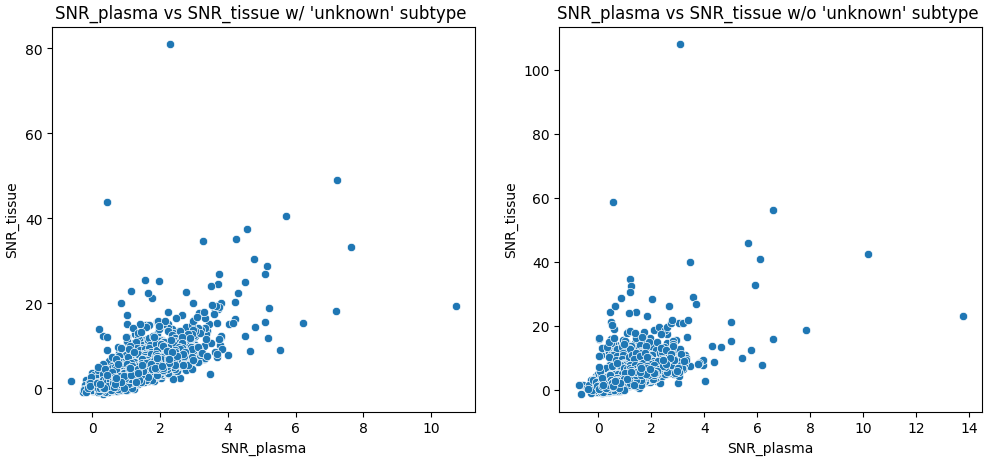

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
        
with plt.style.context('_classic_test_patch'):
        
    sns.scatterplot(x="snr_plasma",
                    y="snr_tissue",
                    data=snrs,
                    ax=axes[0])
    axes[0].set_xlabel("SNR_plasma")
    axes[0].set_ylabel("SNR_tissue")
    axes[0].set_title("SNR_plasma vs SNR_tissue w/ 'unknown' subtype ")

    sns.scatterplot(x="snr_plasma",
                    y="snr_tissue",
                    data=snrs_flt,
                    ax=axes[1])
    axes[1].set_xlabel("SNR_plasma")
    axes[1].set_ylabel("SNR_tissue")
    axes[1].set_title("SNR_plasma vs SNR_tissue w/o 'unknown' subtype ")

## On-off regions

In [19]:
cf_means = df_cf.mean(axis=0)
cf_stds = df_cf.std(axis=0)

meta_columns = ["specimen_type","patient_id"]
tissue_plasma_lung_region_scores = pd.merge(tissue_plasma_lung_region_scores, cluster_dist[meta_columns], how="left", left_index=True, right_index=True)

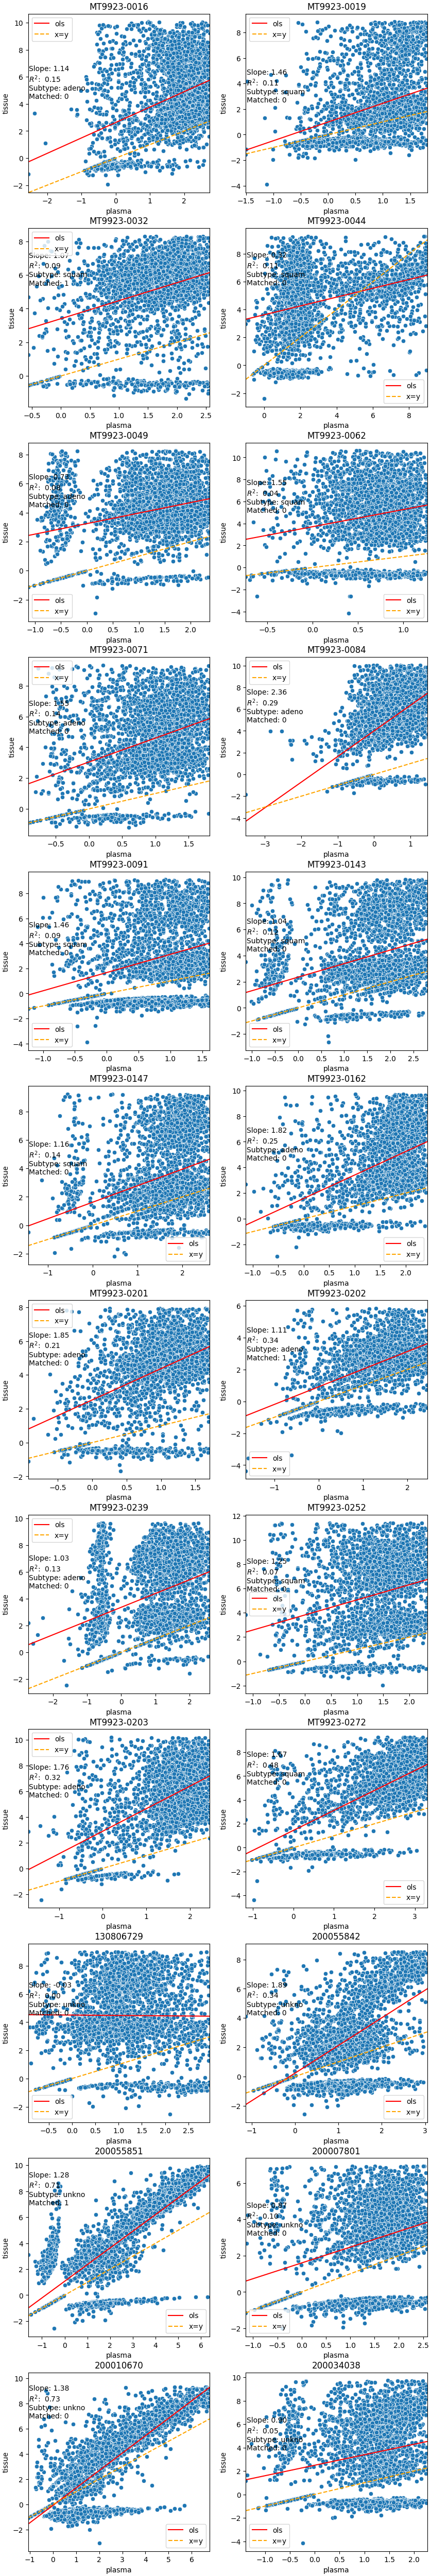

In [20]:
transform = True

res = pd.DataFrame()

fig, axes = plt.subplots(12,2, figsize=(10,64))
axes = axes.flatten()


for idx, id in enumerate(tissue_plasma_lung_region_scores.patient_id.unique()):

    if transform:
        snrs_per_pair = tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                        sort_values("specimen_type").\
                        drop(meta_columns, axis=1).\
                        apply(lambda x: (x-cf_means)/cf_stds, axis=1).\
                        reset_index()
        
        res = pd.concat([res,snrs_per_pair],axis=0)
        
        snrs_per_pair = snrs_per_pair.\
                        pipe(lambda df: df.drop(df.columns[0],axis=1)).\
                        T.\
                        pipe(lambda df: df.rename(columns = dict(zip(df.columns,["plasma","tissue"]))))
    
        snrs_per_pair = snrs_per_pair.query(' plasma <=  plasma.quantile(0.9) and tissue <=  tissue.quantile(0.9) ' )

    else:
        snrs_per_pair = tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                    sort_values("specimen_type").\
                    drop(meta_columns, axis=1).\
                    pipe(lambda df: df.drop(df.columns[0],axis=1)).\
                    T.\
                    pipe(lambda df: df.rename(columns = dict(zip(df.columns,["plasma","tissue"]))))
        snrs_per_pair = snrs_per_pair.query(' plasma <=  plasma.quantile(0.9) and tissue <=  tissue.quantile(0.9) ' )

    sns.scatterplot(x="plasma", y="tissue", data=snrs_per_pair, ax = axes[idx])

    ## linear regression
    model = sm.ols('tissue ~ plasma', data=snrs_per_pair).fit()
    intercept, slope = model.params
    r_squared = model.rsquared

    ## generate regression line
    x_vals = np.array(axes[idx].get_xlim())
    y_vals = intercept + slope * x_vals

    ## meta-info
    subtype = cluster_dist.query('patient_id == @id').histological_subtype.values[0]
    matched = cluster_dist.query('patient_id == @id').matched.values[0]


    axes[idx].plot(x_vals, y_vals, linestyle='-', color='red', label="ols")
    
    axes[idx].axline( (0,0), slope=1, linestyle='--', color='orange', label="x=y")

    axes[idx].set_xlim(snrs_per_pair.plasma.min(),snrs_per_pair.plasma.max())
    
    axes[idx].text(np.quantile(x_vals,0.05) , np.quantile(y_vals, 0.75) , f"Slope: {slope:.2f}\n$R^2$: {r_squared: .2f}\nSubtype: {subtype[:5]}\nMatched: {matched}")

    axes[idx].set_title(f"{id}")
    axes[idx].legend()    

In [21]:
with open('/screening/notebooks/zhuang/summer_2024/data/tissue_plasma_snr_per_pair.pkl', 'wb') as f:
        pickle.dump(res, f)

In [22]:
run = True
tissue_mutiplier = 1

if run:
    thresholds = [int(i) for i in range(1,11)]
    logics = ["And","Or", "Tissue_Only", "Plasma_Only"]
    on_off_dict = {}
    
    for threshold in thresholds:
        
        arr = np.zeros((len(cf_means), len(logics)))
        
        for id in tissue_plasma_lung_region_scores.patient_id.unique():
            on_off = tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                sort_values("specimen_type").\
                drop(meta_columns, axis=1).\
                apply(lambda x: (x-cf_means)/cf_stds, axis=1)
            
            #.\
            #pipe(lambda df: df > threshold)
        
            plasma = on_off.iloc[0,:]
            tissue = on_off.iloc[1,:]
        
            arr[(plasma >= threshold)  & (tissue >= tissue_mutiplier*threshold) , 0] += 1
            arr[ (plasma >= threshold) | (tissue >= tissue_mutiplier*threshold), 1] += 1
            arr[ ~(plasma >= threshold) & (tissue >= tissue_mutiplier*threshold), 2] += 1
            arr[ (plasma >= threshold) & ~(tissue >= tissue_mutiplier*threshold), 3] += 1
        
        arr = arr/len(tissue_plasma_lung_region_scores.patient_id.unique())
        on_off_dict["snr_"+str(threshold)] = pd.DataFrame(arr,
                                                          index = cf_means.index,
                                                          columns = logics)
    with open('/screening/notebooks/zhuang/summer_2024/data/one_off_dict.pkl', 'wb') as f:
        pickle.dump(on_off_dict, f)

else:
    with open('/screening/notebooks/zhuang/summer_2024/data/one_off_dict.pkl', 'rb') as f:
         on_off_dict =  pickle.load(f)

In [23]:
similarity = pd.DataFrame()
thresholds = [int(i) for i in range(1,11)]


for threshold in thresholds:
    jaccard = []
    
    for id in tissue_plasma_lung_region_scores.patient_id.unique():
                on_off = tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                    sort_values("specimen_type").\
                    drop(meta_columns, axis=1).\
                    apply(lambda x: (x-cf_means)/cf_stds, axis=1)
        
                    #.\
                    #pipe(lambda df: df > threshold)
            
                plasma = on_off.iloc[0,:]
                tissue = on_off.iloc[1,:]
    
                intersection = ( (plasma >= threshold) & (tissue >= tissue_mutiplier*threshold) ).sum()
                union = ( (plasma >= threshold) | (tissue >= tissue_mutiplier*threshold) ).sum()
                
                jaccard.append(intersection/union)

    similarity = pd.concat([similarity, pd.DataFrame(jaccard).T],axis=0)

similarity.columns = tissue_plasma_lung_region_scores.patient_id.unique()
similarity.index = thresholds

In [24]:
df_anno = cluster_dist.copy()
df_anno = df_anno[["patient_id","matched"]].drop_duplicates().\
    set_index("patient_id")

similarity = similarity.loc[:,list(df_anno.index)]

row_anno = pd.DataFrame({"SNR_threshold":thresholds},
                        index = thresholds)

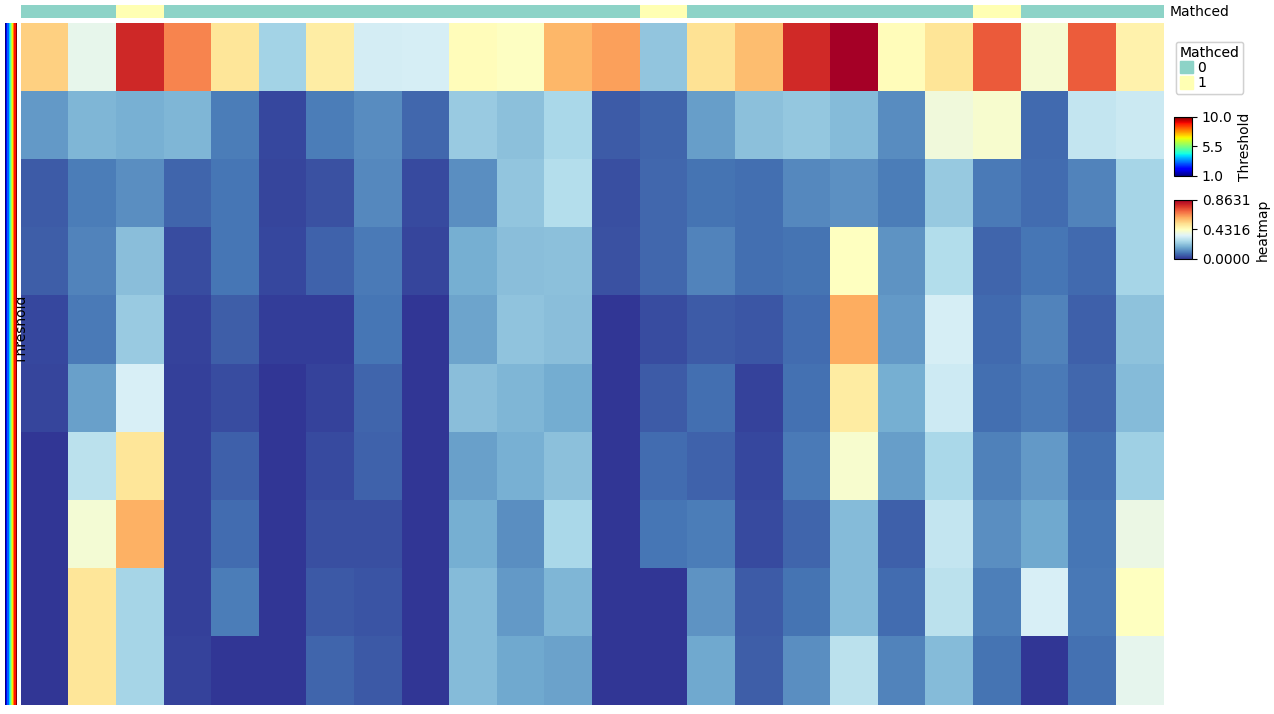

In [29]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  axis=1, 
                                  verbose=False)

row_annot = pyc.HeatmapAnnotation(Threshold=pyc.anno_simple(row_anno.SNR_threshold),
                                  axis=1, 
                                  verbose=False)

cm = pyc.ClusterMapPlotter(data=similarity, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=False,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=4, 
                           col_split_gap=1, 
                           col_cluster=False,
                           row_cluster=False,
                           #row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

cm.ax_heatmap.set_xticks(range(len(similarity.columns)))
cm.ax_heatmap.set_xticklabels(similarity.columns)

cm.ax_heatmap.set_yticks(range(len(row_anno.SNR_threshold)))
cm.ax_heatmap.set_yticklabels(row_anno.SNR_threshold)

plt.show()

In [30]:
freq_threshold = 0.7

logics_summary = pd.DataFrame()

And_count = []
Or_count = []
Tissue_Only_count = []
Plasma_Only_count = []

for key, value in on_off_dict.items():
    
    threshold = int(key.split("_")[1])
    
    tmp = value.agg(['median','mean','max','min']).\
            T.\
            assign(snr_threshold = threshold).\
            reset_index(names="logics")

    logics_summary = pd.concat([logics_summary, tmp],axis=0)

    And_count.append(len(value.query('And >= @freq_threshold')))
    Or_count.append(len(value.query('Or >= @freq_threshold')))
    Tissue_Only_count.append(len(value.query('Tissue_Only >= @freq_threshold')))
    Plasma_Only_count.append(len(value.query('Plasma_Only >= @freq_threshold')))

count_summary = pd.DataFrame({"snr_threshold":[int(i) for i in range(1,11)],
                               "And_count": np.array(And_count)/len(cf_means),
                               "Or_count": np.array(Or_count)/len(cf_means),
                               "Tissue_Only_count": np.array(Tissue_Only_count)/len(cf_means),
                               "Plasma_Only_count": np.array(Plasma_Only_count)/len(cf_means)})

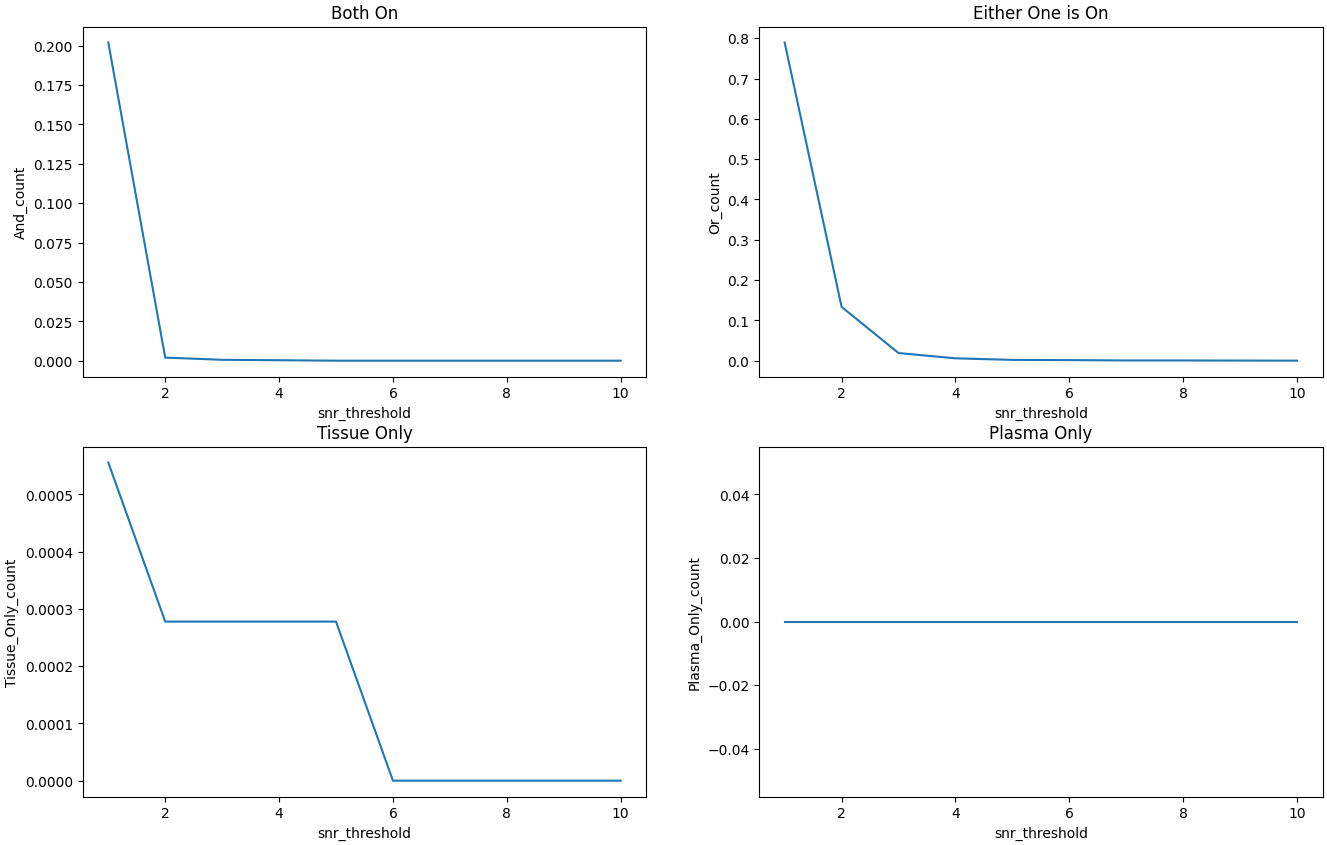

In [31]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="snr_threshold",
                 y="And_count",
                 data=count_summary,
                 ax=axes[0,0])
    
    axes[0,0].set_title("Both On")

    sns.lineplot(x="snr_threshold",
                 y="Or_count",
                 data=count_summary,
                 ax=axes[0,1])
    
    axes[0,1].set_title("Either One is On")

    sns.lineplot(x="snr_threshold",
                 y="Tissue_Only_count",
                 data=count_summary,
                 ax=axes[1,0])
    
    axes[1,0].set_title("Tissue Only")

    sns.lineplot(x="snr_threshold",
                 y="Plasma_Only_count",
                 data=count_summary,
                 ax=axes[1,1])
    
    axes[1,1].set_title("Plasma Only")

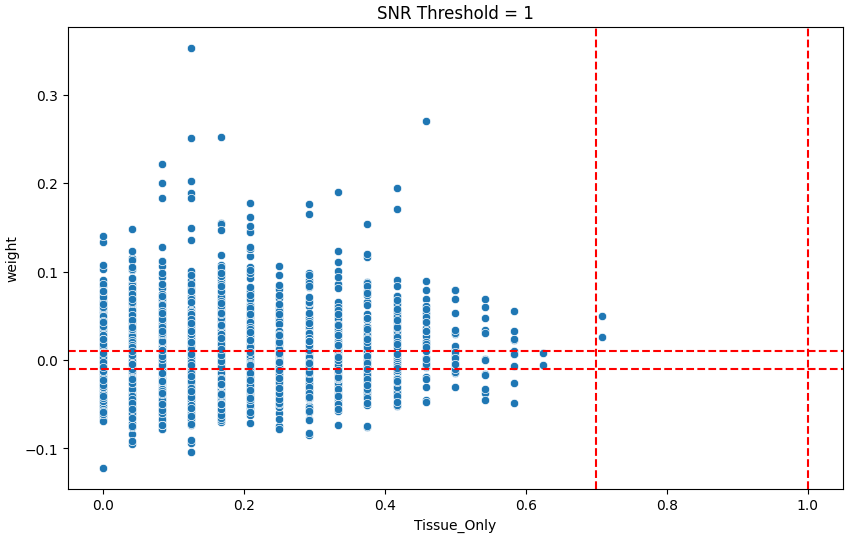

In [39]:
tmp = on_off_dict['snr_1'].\
    reset_index(names="region_id").\
    merge(s3_v4_model, on="region_id",how='left')

abs_weight_quantile = 0.3
freq_threshold = 0.7

fig, axes = plt.subplots(figsize=(10,6))
        
with plt.style.context('_classic_test_patch'):
        
   
    sns.scatterplot(x="Tissue_Only",
                    y="weight",
                    data=tmp,
                    ax=axes)

    axes.set_title("SNR Threshold = 1")

    
    plt.axvline(freq_threshold, 0, linestyle="--", color="red")
    plt.axvline(1, 0, linestyle="--", color="red")
    plt.axhline(s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")
    plt.axhline(-s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")


regions_of_interest = tmp.query('Tissue_Only >= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id

## Heatmap

In [53]:
df_exprs = tissue_plasma_lung_z.T
#df_exprs = tissue_plasma_lung_region_scores.drop(["specimen_type","patient_id"],axis=1).\
    #apply(lambda x: zscore(x), axis=1).\
    #T
df_exprs[df_exprs > 5] = 5

## column annotation
df_anno = cluster_dist.copy()
df_anno.specimen_type = df_anno.specimen_type.astype("object")
#df_anno = df_anno.sort_values(["matched","patient_id","specimen_type"],ascending=False)
df_anno = df_anno.sort_values(["specimen_type"],ascending=False)

## 
#matched_sample_ids = list(df_anno.query("matched == 1").index)
df_exprs = df_exprs.loc[:,list(df_anno.index)]

In [54]:
df_exprs.max().max()

5.0

In [55]:
region_anno = tmp.copy().\
    assign(roi = lambda df: np.where(df["region_id"].isin(regions_of_interest),"yes","no")).\
    set_index("region_id")

region_anno.head()

And        Or  Tissue_Only  Plasma_Only    weight  \
region_id                                                                 
s3_region_26389  0.000000  0.083333     0.041667     0.041667 -0.007742   
s3_region_22508  0.000000  0.333333     0.208333     0.125000 -0.007395   
s3_region_22604  0.166667  0.833333     0.625000     0.041667 -0.043765   
s3_region_26760  0.000000  0.083333     0.041667     0.041667  0.010122   
s3_region_17285  0.000000  0.166667     0.041667     0.125000  0.012652   

                     bias  threshold  pseudocount roi  
region_id                                              
s3_region_26389 -0.003738 -20.343955      0.00001  no  
s3_region_22508 -0.003738 -20.343955      0.00001  no  
s3_region_22604 -0.003738 -20.343955      0.00001  no  
s3_region_26760 -0.003738 -20.343955      0.00001  no  
s3_region_17285 -0.003738 -20.343955      0.00001  no

Starting plotting HeatmapAnnotations


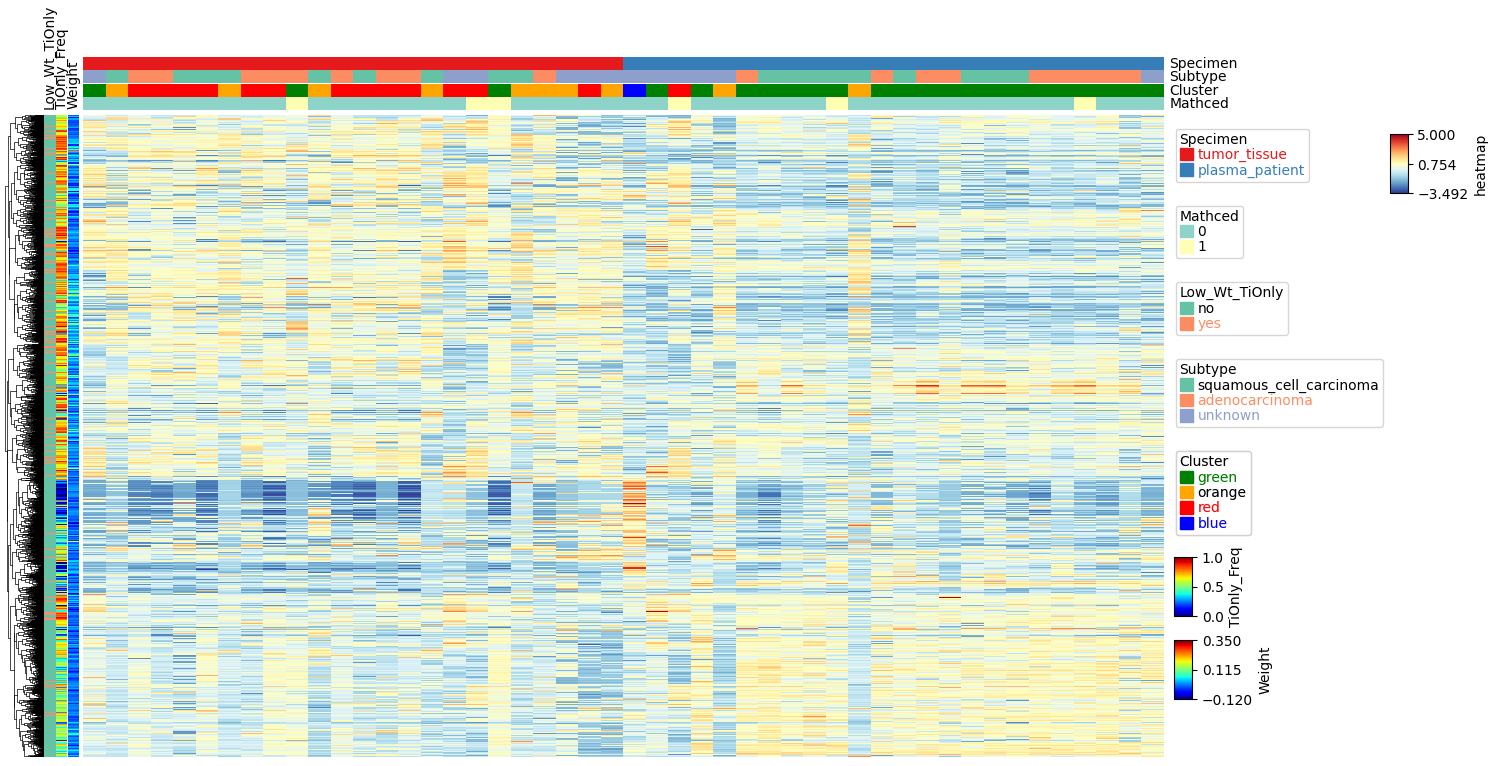

In [51]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Specimen=pyc.anno_simple(df_anno.specimen_type, cmap='Set1'),
                                  Subtype=pyc.anno_simple(df_anno.histological_subtype, cmap='Set2'),
                                  Cluster=pyc.anno_simple(df_anno.cluster_samples, colors={"green":"green","orange":"orange","red":"red","blue":"blue"}),
                                  Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  axis=1, 
                                  verbose=False)


row_annot = pyc.HeatmapAnnotation(Low_Wt_TiOnly=pyc.anno_simple(region_anno.roi,cmap="Set2"), 
                                  TiOnly_Freq=pyc.anno_simple(region_anno.Tissue_Only),
                                  Weight=pyc.anno_simple(region_anno.weight), 
                                  axis=0)


#cmap = define_cmap(df_exprs, center=0, vmax=5, vmin=-5, cmap='jet')[0]

cm = pyc.ClusterMapPlotter(data=df_exprs, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=False,  
                           row_dendrogram=True,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=4, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster=False,
                           #col_cluster_method='complete', 
                           verbose=False)

plt.show()

In [132]:
snrs = tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                sort_values("specimen_type").\
                drop(meta_columns, axis=1).\
                apply(lambda x: x-cf_means/cf_stds, axis=1).\
                reset_index().\
                pipe(lambda df: df.drop(df.columns[0],axis=1)).\
                T.\
                pipe(lambda df: df.rename(columns = dict(zip(df.columns,["plasma","tissue"]))))

#"MT9923-0032"

In [133]:
q90_plasma = snrs.iloc[:,0].quantile(0.90)
q90_tissue = snrs.iloc[:,1].quantile(0.90)

In [134]:
snrs.iloc[:,0][snrs.iloc[:,0] > q90_plasma] = q90_plasma

In [135]:
snrs.iloc[:,1][snrs.iloc[:,1] > q90_tissue] = q90_tissue

In [100]:
tissue_plasma_lung_region_scores.query(' patient_id == @id ').\
                sort_values("specimen_type").\
                drop(meta_columns, axis=1).\
                apply(lambda x: x-cf_means/cf_stds, axis=1)

s3_region_26389  s3_region_22508  s3_region_22604  \
run_sample_id                                                                
DEI0074_010_s0MLcpaqVh6        13.825717        21.445834        21.163719   
DEI0074_048_AyCiG59L9dZ        12.927664        20.992200        21.225882   

                         s3_region_26760  s3_region_17285  s3_region_8296  \
run_sample_id                                                               
DEI0074_010_s0MLcpaqVh6        21.244952        23.832002       20.856993   
DEI0074_048_AyCiG59L9dZ        21.080446        23.415061       20.524294   

                         s3_region_27052  s3_region_19545  s3_region_23501  \
run_sample_id                                                                
DEI0074_010_s0MLcpaqVh6        25.081205        19.723611        16.854689   
DEI0074_048_AyCiG59L9dZ        24.797670        18.957539        17.507434   

                         s3_region_15145  ...  merged_462  merged_184  \
run_sample_id                             ...                           
DEI0074_010_s0MLcpaqVh6        22.126271  ...    7.201813    9.092950   
DEI0074_048_AyCiG59L9dZ        21.842736  ...    9.195095   10.239432   

                         s3_region_3718  s3_region_13486  s3_region_27348  \
run_sample_id                                                               
DEI0074_010_s0MLcpaqVh6        8.835601         7.541326        10.995399   
DEI0074_048_AyCiG59L9dZ       10.778147         9.540087        10.476546   

                         s3_region_27149  s3_region_8257  s3_region_16209  \
run_sample_id                                                               
DEI0074_010_s0MLcpaqVh6         7.047486       13.204988        10.695566   
DEI0074_048_AyCiG59L9dZ         9.360799       13.765980        13.031560   

                         s3_region_8258  s3_region_19  
run_sample_id                                          
DEI0074_010_s0MLcpaqVh6        8.865295      5.210010  
DEI0074_048_AyCiG59L9dZ        9.114694      5.687548  

[2 rows x 3598 columns]

In [112]:
res = {}

model = sm.ols(formula="tissue~plasma",
                data=snrs).fit()


In [113]:
snrs.max()

plasma    394.585831
tissue    394.585831
dtype: float64

In [109]:
model.params

Intercept    1.511144
plasma       0.980895
dtype: float64

In [32]:
res['r2'] = model.rsquared
res['r2_adj'] = model.rsquared_adj
res['coefficient'] = pd.DataFrame("coefficient":model.params,
                                    "pvalue":model.pvalues})


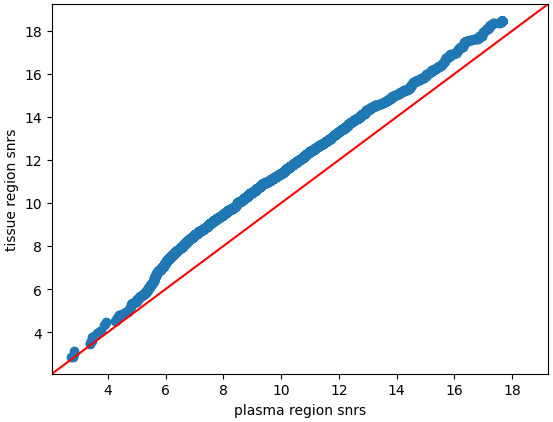

In [136]:
col1= snrs["plasma"]
col2 = snrs["tissue"]

import statsmodels.api as sm
fig = sm.qqplot_2samples(col1, col2, line="45")
plt.xlabel("plasma region snrs")
plt.ylabel("tissue region snrs")
plt.show()

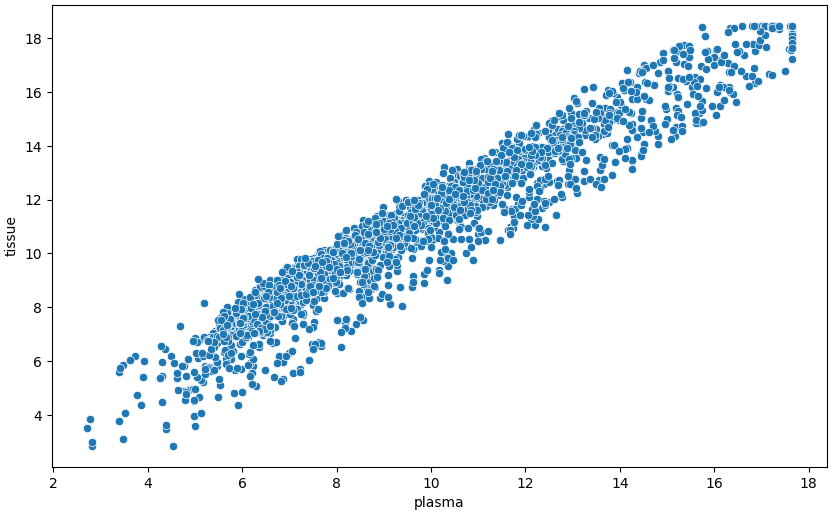

In [127]:
fig, axes = plt.subplots(figsize=(10,6))
        
with plt.style.context('_classic_test_patch'):
        
    sns.scatterplot(x="plasma",
                    y="tissue",
                    data=snrs)

<Axes: >

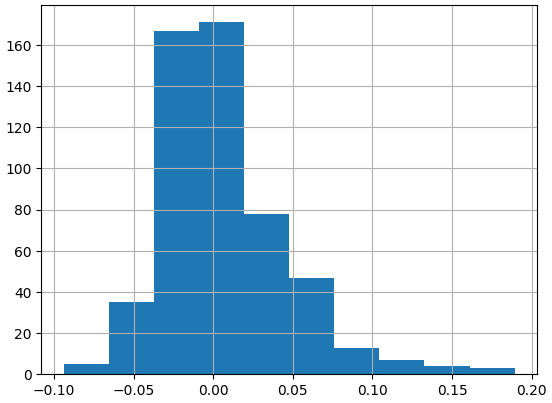

In [35]:
s3_v4_model.query('region_id.isin(@tissue_only_regions) ').weight.hist()

<Axes: >

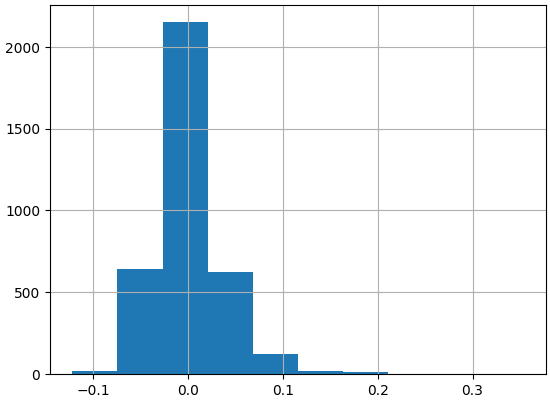

In [36]:
s3_v4_model.weight.hist()

In [39]:
region_anno.on_tissue.sum()

1675

In [60]:
num_regions =len(cf_means)

count_arr = np.zeros((num_regions, 4))
count_arr.shape

(3598, 4)

In [61]:
count_arr[plasma & ~tissue, 2] += 1

In [64]:
count_arr[:,2].sum()

14.0

In [41]:
region_anno.query(' on_tissue == 1 and on_plasma == 1 ').shape

(12, 9)

In [30]:
tmp = pd.merge(tissue_plasma_lung_region_scores, cluster_dist[["specimen_type","patient_id"]], how="left", left_index=True, right_index=True)

In [31]:
tmp.patient_id.unique()

array(['MT9923-0016', 'MT9923-0019', 'MT9923-0032', 'MT9923-0044',
       'MT9923-0049', 'MT9923-0062', 'MT9923-0071', 'MT9923-0084',
       'MT9923-0091', 'MT9923-0143', 'MT9923-0147', 'MT9923-0162',
       'MT9923-0201', 'MT9923-0202', 'MT9923-0239', 'MT9923-0252',
       'MT9923-0203', 'MT9923-0272', '130806729', '200055842',
       '200055851', '200007801', '200010670', '200034038'], dtype=object)

In [33]:
tmp.query(' patient_id == "MT9923-0016" and specimen_type == "tumor_tissue" ')

s3_region_26389  s3_region_22508  s3_region_22604  \
run_sample_id                                                                
DEI0074_046_uVB4NHeGBnR             -5.0        -4.045696             -5.0   

                         s3_region_26760  s3_region_17285  s3_region_8296  \
run_sample_id                                                               
DEI0074_046_uVB4NHeGBnR             -5.0             -5.0            -5.0   

                         s3_region_27052  s3_region_19545  s3_region_23501  \
run_sample_id                                                                
DEI0074_046_uVB4NHeGBnR             -5.0             -5.0         -3.93299   

                         s3_region_15145  ...  s3_region_3718  \
run_sample_id                             ...                   
DEI0074_046_uVB4NHeGBnR             -5.0  ...       -2.519445   

                         s3_region_13486  s3_region_27348  s3_region_27149  \
run_sample_id                                                                
DEI0074_046_uVB4NHeGBnR        -1.624389             -5.0        -3.334038   

                         s3_region_8257  s3_region_16209  s3_region_8258  \
run_sample_id                                                              
DEI0074_046_uVB4NHeGBnR       -4.045696        -4.045696        -3.93299   

                         s3_region_19  specimen_type   patient_id  
run_sample_id                                                      
DEI0074_046_uVB4NHeGBnR     -1.981369   tumor_tissue  MT9923-0016  

[1 rows x 3600 columns]